# Import Libraries

In [5]:
import os
import time
import shutil
import pathlib
import itertools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
import warnings
warnings.filterwarnings("ignore")

print ('modules imported')

modules imported


# Load Data

In [6]:
tf.__version__

'2.16.1'

In [7]:
train_data_path = 'dataset/train'
test_data_path = 'dataset/test'
valid_data_path = 'dataset/val'

In [8]:
labels = os.listdir(valid_data_path)

Creating data working directory

In [11]:
data_path = 'data'

if not os.path.exists(data_path):
    os.mkdir(data_path)
    print("Created Succesfulley!")
else:
    print("Folder already exist")

Created Succesfulley!


In [12]:
normal_data_path = 'data/Normal'
oscc_data_path = 'data/OSCC'

if not os.path.exists(normal_data_path):
    os.mkdir(normal_data_path)
    print("Created Succesfulley!")
else:
    print("Folder already exist")
    
if not os.path.exists(oscc_data_path):
    os.mkdir(oscc_data_path)
    print("Created Succesfulley!")
else:
    print("Folder already exist")

Created Succesfulley!
Created Succesfulley!


Moving all the images to the data working directory

In [13]:
def move_data(d_path, saved_path):
    for i in labels:
        images = os.listdir(d_path + '/' + i)
        for j in images:
            path = d_path +'/' + i
            img = cv2.imread(path + '/' + j)
            s_path = saved_path + '/' + i + '/' + j
            cv2.imwrite(s_path, img)

In [14]:
move_data(train_data_path, data_path)

In [15]:
norm_path = len(os.listdir(data_path + '/' + labels[0]))
oscc_path = len(os.listdir(data_path + '/' + labels[1]))
print(norm_path+oscc_path)

4946


In [16]:
move_data(test_data_path, data_path)

In [17]:
norm_path = len(os.listdir(data_path + '/' + labels[0]))
oscc_path = len(os.listdir(data_path + '/' + labels[1]))
print(norm_path+oscc_path)

5072


In [18]:
move_data(valid_data_path, data_path)

In [19]:
norm_path = len(os.listdir(data_path + '/' + labels[0]))
oscc_path = len(os.listdir(data_path + '/' + labels[1]))
print(norm_path+oscc_path)

5192


# EDA

### Define data path and dataset name

In [20]:
data_dir = 'data'
ds_name = 'Oral Cancer'

### Create Dataframe

In [21]:
# Let's Generate data paths with labels

def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [22]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [23]:
df.head()

filepaths labels
0  data/OSCC/OSCC_400x_426.jpg   OSCC
1  data/OSCC/OSCC_400x_340.jpg   OSCC
2  data/OSCC/OSCC_400x_354.jpg   OSCC
3   data/OSCC/aug_219_8212.jpg   OSCC
4  data/OSCC/OSCC_400x_432.jpg   OSCC

### Number of Examples in the dataset

In [24]:
def num_of_examples(df, name='df'):
    print(f"{name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

Oral Cancer dataset has 5192 images.


### Number of Classes in the dataset

The Oral Cancer dataset has 2 classes


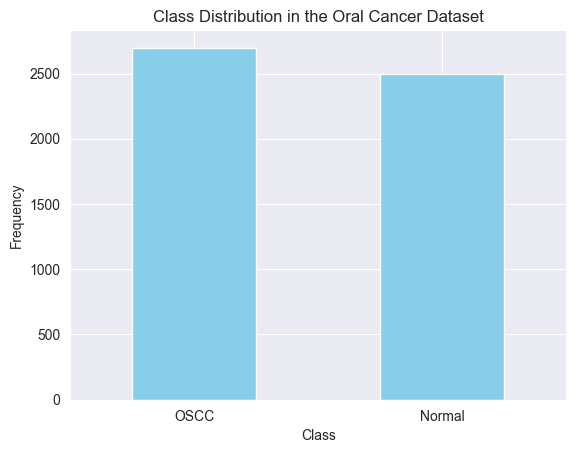

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

def num_of_classes(df, name='dataset'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")
    return df['labels'].value_counts()

ds_name = "Oral Cancer"
class_counts = num_of_classes(df, ds_name)

# Plotting
fig, ax = plt.subplots()
class_counts.plot(kind='bar', ax=ax, color='skyblue')
ax.set_title(f'Class Distribution in the {ds_name} Dataset')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
plt.xticks(rotation=0)  # Rotates labels to make them readable
plt.show()


###  No of images in each class of the dataset

In [28]:
def classes_count(df, name='df'):
    
    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)
        
classes_count(df, ds_name)

The Oral Cancer dataset has: 

Class 'OSCC' has 2698 images
----------------------------------------------------------------------
Class 'Normal' has 2494 images
----------------------------------------------------------------------


### Let's  Visualize Each Class in the dataset

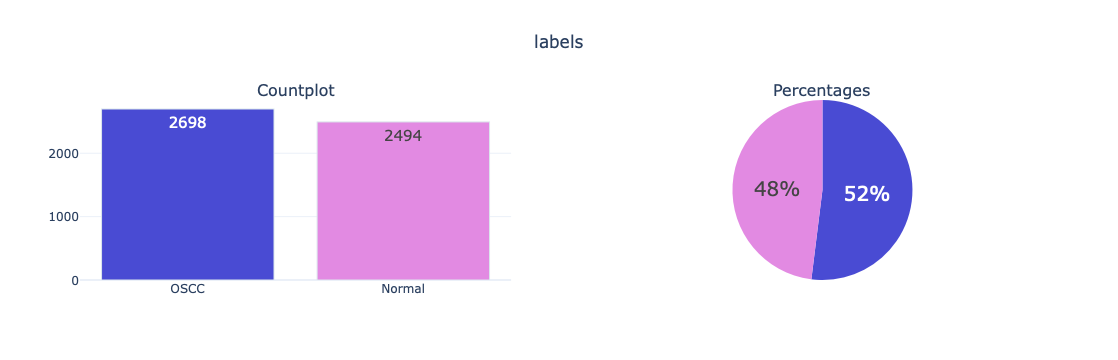

In [29]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)
    
    
colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df,'labels')

### Checking Null values in the dataframe

In [30]:
def check_null_values(df, name='df'):
    
    num_null_vals = sum(df.isnull().sum().values)
    
    if not num_null_vals:
        print(f"The {name} dataset has no null values")
    
    else:
        print(f"The {name} dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())
        

check_null_values(df, ds_name)

The Oral Cancer dataset has no null values


## Split dataframe into train, valid, and test

In [31]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [32]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Oral Cancer dataset has 2 classes
The Validation Oral Cancer dataset has 2 classes
The Testing Oral Cancer dataset has 2 classes


labels
OSCC      390
Normal    389
Name: count, dtype: int64

In [33]:
classes_count(train_df, 'Training '+ds_name)

The Training Oral Cancer dataset has: 

Class 'OSCC' has 1911 images
----------------------------------------------------------------------
Class 'Normal' has 1723 images
----------------------------------------------------------------------


In [34]:
classes_count(valid_df, 'Validation '+ds_name)

The Validation Oral Cancer dataset has: 

Class 'Normal' has 382 images
----------------------------------------------------------------------
Class 'OSCC' has 397 images
----------------------------------------------------------------------


In [35]:
classes_count(test_df, 'Testing '+ds_name)

The Testing Oral Cancer dataset has: 

Class 'OSCC' has 390 images
----------------------------------------------------------------------
Class 'Normal' has 389 images
----------------------------------------------------------------------


## Let's Create Image Data Generator

In [36]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           horizontal_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 3634 validated image filenames belonging to 2 classes.
Found 779 validated image filenames belonging to 2 classes.
Found 779 validated image filenames belonging to 2 classes.


### Visualize Training dataset

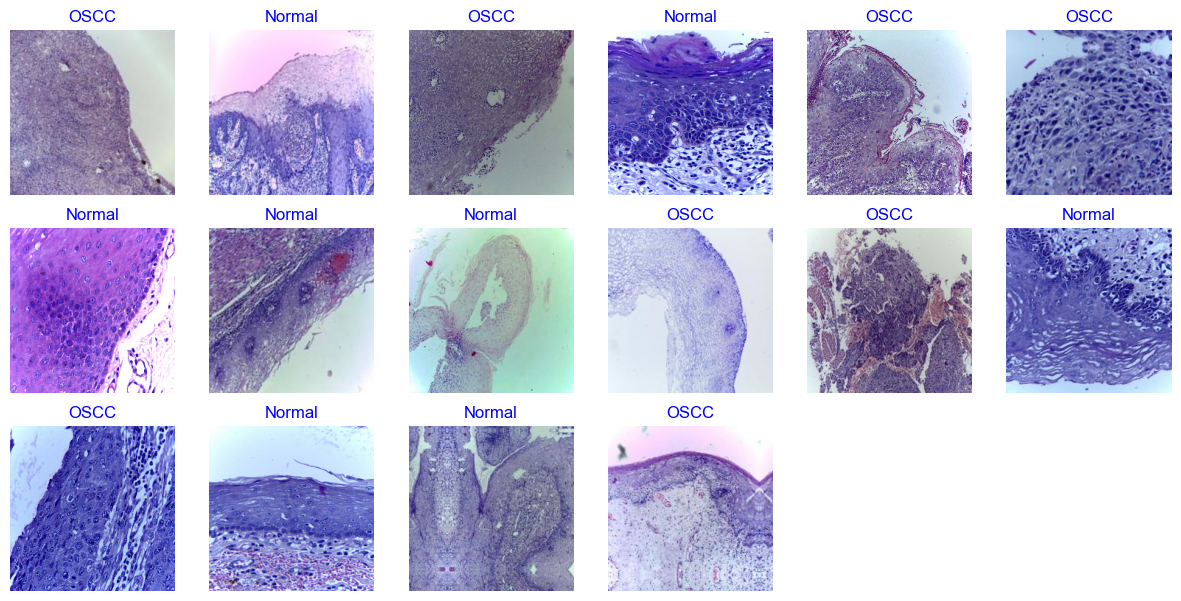

In [41]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen) 

plt.figure(figsize= (15, 15))

for i in range(16):
    plt.subplot(6, 6, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
    
plt.show()

# Models

### Generic Model

In [43]:
# Correct model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.EfficientNetB3(
    include_top=False, 
    weights="imagenet", 
    input_shape=img_shape, 
    pooling='max'
)

efficentNet_model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016),  # Corrected here
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

efficentNet_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

efficentNet_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

### Early Stop

In [44]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               restore_best_weights=True,
                               mode='min',
                              )

### Let's Train the Model

In [45]:
batch_size = 128   # set batch size for training
epochs = 100   # number of all epochs in training

history = efficentNet_model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen, 
                    validation_steps= None,
                    shuffle= False,
                    batch_size= batch_size)

Epoch 1/100


2024-04-16 20:12:00.701906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


228/228 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.5989 - loss: 12.1926 - val_accuracy: 0.5353 - val_loss: 5.6244
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.5414 - loss: 5.1147 - val_accuracy: 0.5148 - val_loss: 4.0747
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.5265 - loss: 3.7716 - val_accuracy: 0.5160 - val_loss: 3.0698
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.5357 - loss: 2.8107 - val_accuracy: 0.5173 - val_loss: 2.3946
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.5362 - loss: 2.1731 - val_accuracy: 0.5148 - val_loss: 2.0061
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.5264 - loss: 1.7572 - val_accuracy: 0.5276 - val_loss: 1.6311
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.5349 - loss: 1.4499 - val_accuracy: 0.5160 - val_loss: 1.3807
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.5364 - loss: 1.2213 - val_accurac

### Model Evaluation

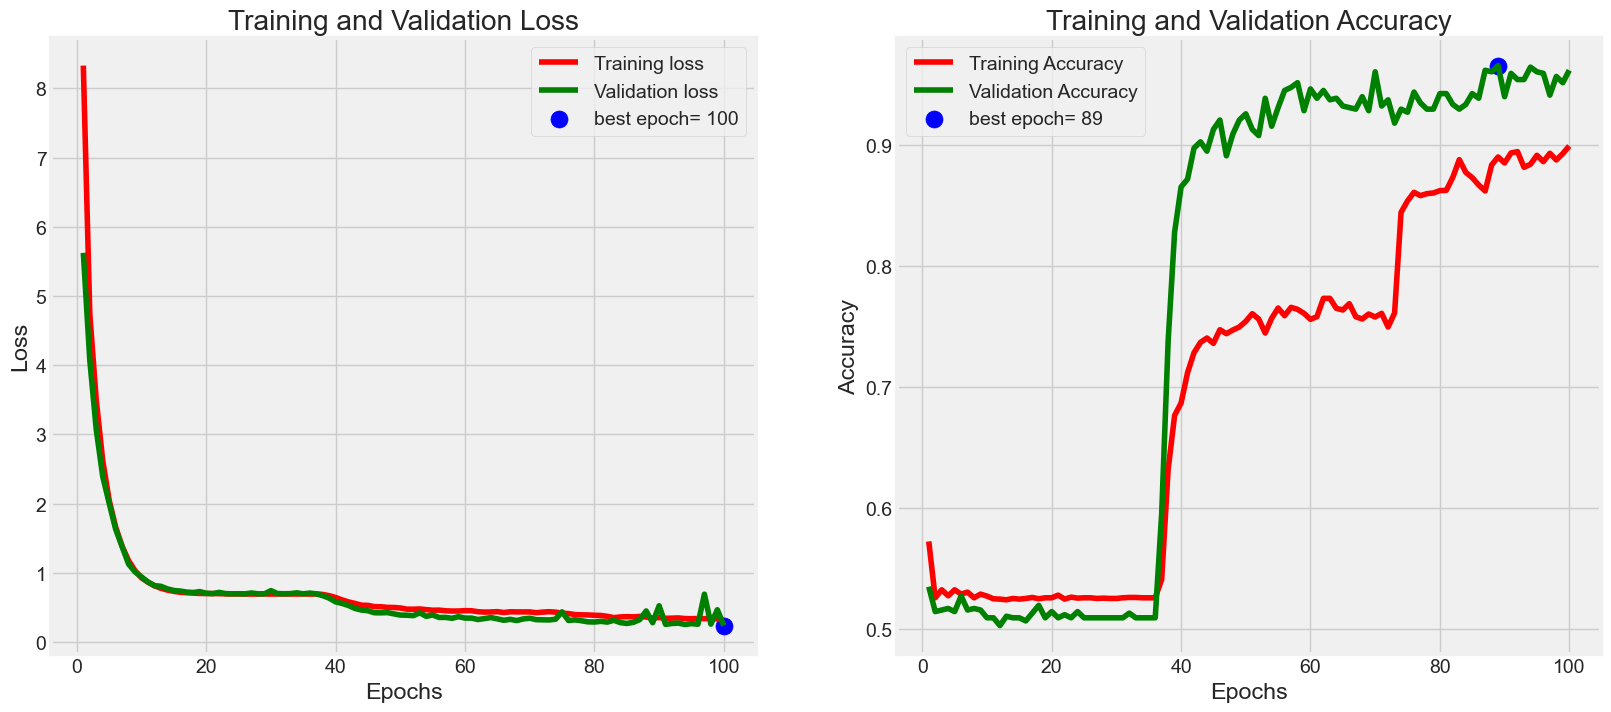

In [46]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

### Let's calculate the model accuray

In [47]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = efficentNet_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = efficentNet_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = efficentNet_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9701 - loss: 0.2293
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9392 - loss: 0.2831
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 440ms/step - accuracy: 0.9786 - loss: 0.3343
Train Loss:  0.20888178050518036
Train Accuracy:  0.9835526347160339
--------------------
Validation Loss:  0.26151010394096375
Validation Accuracy:  0.9539473652839661
--------------------
Test Loss:  0.3370945155620575
Test Accuracy:  0.973042368888855


### Get Prediction

In [53]:
preds = efficentNet_model.predict(test_gen, steps=test_steps)
y_pred = np.argmax(preds, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 447ms/step


### Confussion Matrix</b>

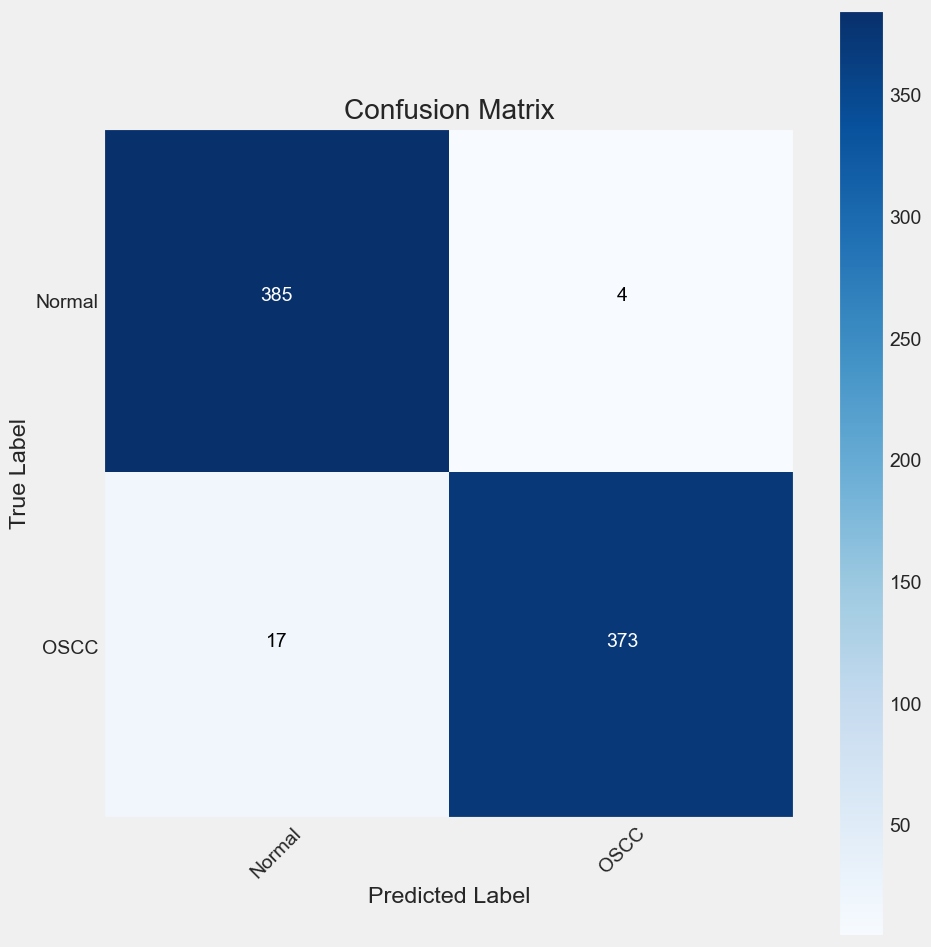

In [54]:
#'test_gen' is testing data generator and 'y_pred' is the array of predictions
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Calculate the confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

# Create the plot
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Setting tick marks and labels for classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Determine text color based on background
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

# Additional styling
plt.gca().set_facecolor('white')
plt.grid(False)  
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()  # Adjust layout to make room for rotated x-labels
plt.show()

### Classification Report

In [55]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97       389
        OSCC       0.99      0.96      0.97       390

    accuracy                           0.97       779
   macro avg       0.97      0.97      0.97       779
weighted avg       0.97      0.97      0.97       779



### Let's Save the Model For Future Use

In [59]:
efficentNet_model.save_weights('my_model.weights.h5')

In [66]:
import os

# Absolute path for clarity
file_path = os.path.abspath('efficentNet_model.keras')

# Ensure the file is deleted before saving
if os.path.exists(file_path):
    os.remove(file_path)
    print("File deleted successfully.")
else:
    print("File does not exist.")

# Try saving the model in the new .keras format
try:
    efficentNet_model.save(file_path)  # '.keras' extension is used
    print("Model saved successfully in Keras format at:", file_path)
except Exception as e:
    print("Failed to save the model in Keras format:", e)

File does not exist.
Model saved successfully in Keras format at: /Users/raja/Desktop/Career/Masters/Universities/mtu/Spring2024/SAT5114/Final Project/efficentNet_model.keras


### Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


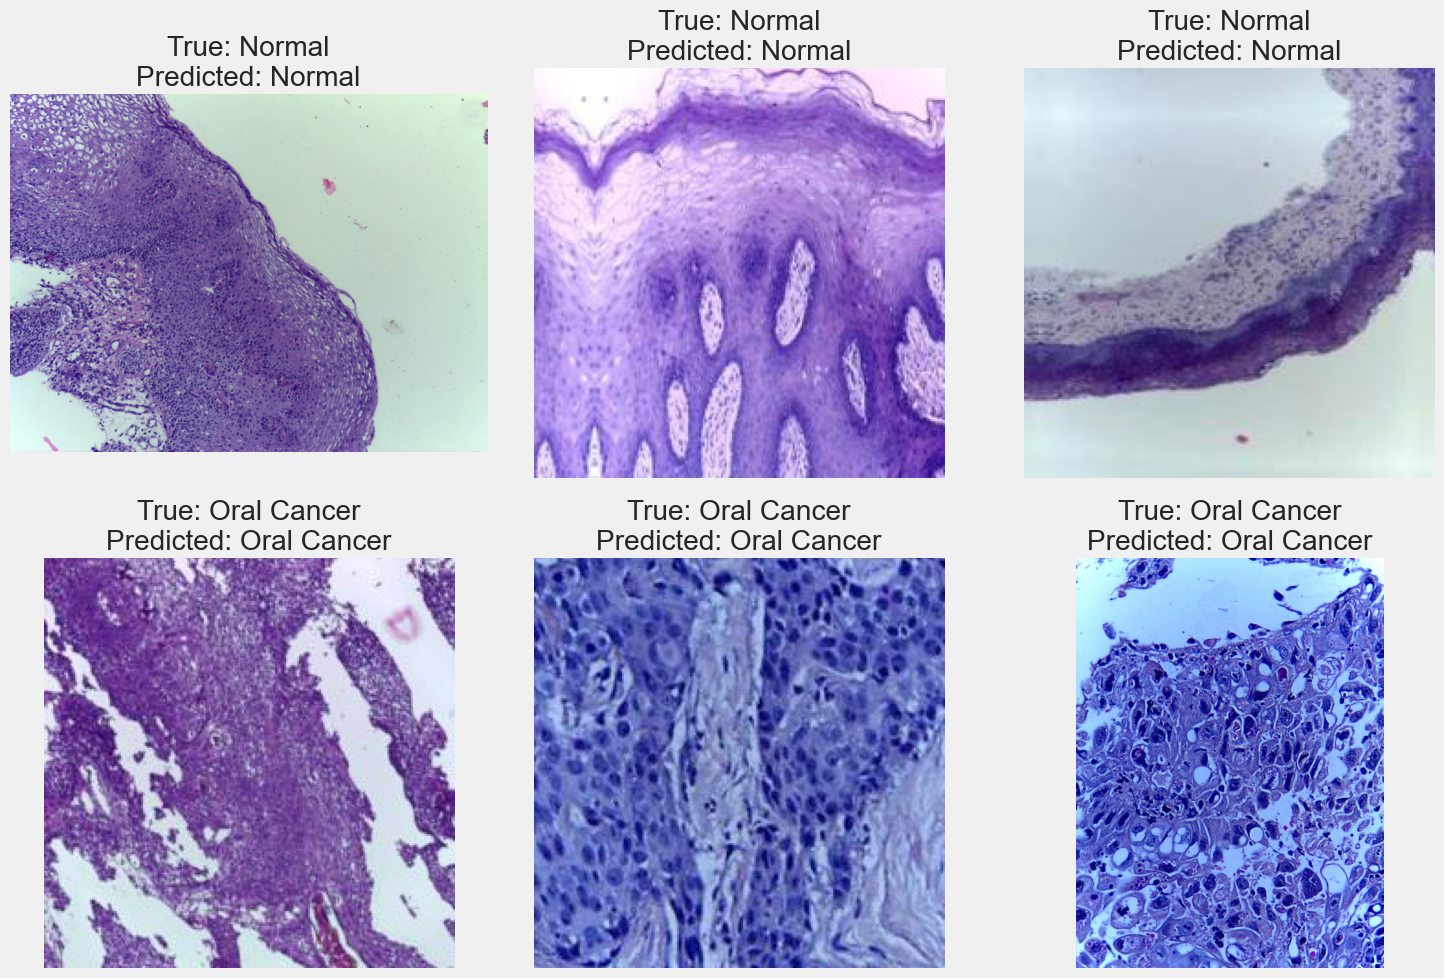

In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
import random

def predict_and_display(directory_normal, directory_cancer, model, num_images=3):
    # List files in each directory
    normal_images = [os.path.join(directory_normal, img) for img in os.listdir(directory_normal)]
    cancer_images = [os.path.join(directory_cancer, img) for img in os.listdir(directory_cancer)]
    
    # Randomly select images
    selected_normal = random.sample(normal_images, num_images)
    selected_cancer = random.sample(cancer_images, num_images)
    
    # Concatenate all selected images
    selected_images = selected_normal + selected_cancer
    true_labels = ['Normal'] * num_images + ['Oral Cancer'] * num_images
    
    plt.figure(figsize=(15, 10))
    
    for i, (img_path, true_label) in enumerate(zip(selected_images, true_labels), 1):
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction)
        predicted_class_label = class_labels[predicted_class_index]
        
        # Plotting
        ax = plt.subplot(2, 3, i)
        plt.imshow(image.load_img(img_path))
        plt.title(f"True: {true_label}\nPredicted: {predicted_class_label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 'efficentNet_model' is  compiled
class_labels = ['Normal', 'Oral Cancer']
directory_normal = 'data/Normal/'
directory_cancer = 'data/OSCC/'

# Predict and display images
predict_and_display(directory_normal, directory_cancer, efficentNet_model, num_images=3)